In [1]:
# Dependencies
!pip install nltk
import pandas as pd
import re
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout

Data = pd.read_csv('/content/drive/My Drive/Dicoding/Submission/Submission_1/Data_Berita.csv', sep=';')
Data.head()

,Story,Category
0,But the most painful was the huge reversal in ...,Business
1,How formidable is the opposition alliance amon...,Politics
2,Most Asian currencies were trading lower today...,Business
3,"If you want to answer any question, click on ‘...",Technology
4,"In global markets, gold prices edged up today ...",Business


Sumber Data https://www.kaggle.com/akash14/news-category-dataset

In [2]:
# Preprocessing
# Menghilangkan Baris yang memiliki data kosong
Data.dropna(inplace=True)

# Menghapus Tanda Baca pada Story
Data['Story'] = Data['Story'].map(lambda x: re.sub(r'\W+',' ', x))

# Menghapus Stopwords
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
Data['Story'] = Data['Story'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

Data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Story,Category
0,But painful huge reversal fee income unheard a...,Business
1,How formidable opposition alliance among Congr...,Politics
2,Most Asian currencies trading lower today Sout...,Business
3,If want answer question click Answer After cli...,Technology
4,In global markets gold prices edged today disa...,Business
...,...,...
7623,Karnataka Congress bastion also gave BJP first...,Politics
7624,The film also features Janhvi Kapoor revolve a...,Entertainment
7625,The database created bringing together crimina...,Technology
7626,The state uneasy relationship mainland since d...,Politics


<Figure size 720x576 with 0 Axes>

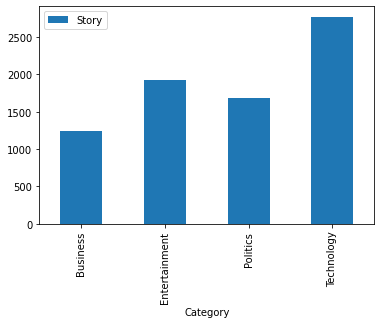

In [3]:
#count values for each category
plt.figure(figsize=(10,8))
Data.groupby('Category').count().plot.bar(ylim=0)
plt.show()

Jumlah Setiap Kelas hampir sama, Sehingga tidak diperlukan perlakuan lebih lanjut


In [4]:
category = pd.get_dummies(Data.Category)
Data = pd.concat([Data, category], axis=1)
Data = Data.drop(columns='Category')
Data

,Story,Business,Entertainment,Politics,Technology
0,But painful huge reversal fee income unheard a...,1,0,0,0
1,How formidable opposition alliance among Congr...,0,0,1,0
2,Most Asian currencies trading lower today Sout...,1,0,0,0
3,If want answer question click Answer After cli...,0,0,0,1
4,In global markets gold prices edged today disa...,1,0,0,0
...,...,...,...,...,...
7623,Karnataka Congress bastion also gave BJP first...,0,0,1,0
7624,The film also features Janhvi Kapoor revolve a...,0,1,0,0
7625,The database created bringing together crimina...,0,0,0,1
7626,The state uneasy relationship mainland since d...,0,0,1,0


In [5]:
#Convert Data string ke np.array
text = Data['Story'].astype(str)
label = Data[['Business','Entertainment','Politics','Technology']].values

#Split Data 80,20
story_train, story_test, label_train, label_test = train_test_split(text, label,test_size = 0.2)

In [6]:
#Tokenizing
token = Tokenizer(num_words= 10000, oov_token = 'x')

token.fit_on_texts(story_train)
token.fit_on_texts(story_test)
tok_train = token.texts_to_sequences(story_train)
tok_test= token.texts_to_sequences(story_test)

#Padding
pad_train = pad_sequences(tok_train)
pad_test = pad_sequences(tok_test)

Membuat Model

In [7]:
#Membuat Model Sequential
Model = tf.keras.Sequential([
    Embedding(input_dim=10000, output_dim=16),
    LSTM(64),
    Dense(128, activation='elu'),
    Dense(256, activation='elu'),
    Dense(128, activation='elu'),
    Dense(64, activation='selu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

#Setting Optimizer Adam
Adam(learning_rate = 0.001, name = 'Adam')

#Compile Model
Model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [9]:
#Set Callback
class Panggilkembali(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.95):
      print("\nAkurasi validasi sudah > 95%!")
      self.model.stop_training = True
callbacks = Panggilkembali()

In [10]:
#Train Model
history = Model.fit(pad_train, label_train, epochs=100, validation_data=(pad_test, label_test), verbose=3, callbacks=[callbacks])

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100

Akurasi validasi sudah > 95%!


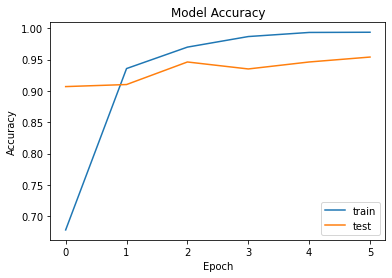

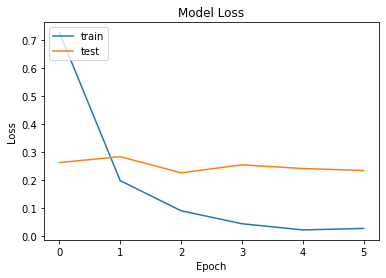

In [11]:
#acc plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

#loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
Model.evaluate(pad_test, label_test)

48/48 [==============================] - 4s 83ms/step - loss: 0.2348 - accuracy: 0.9541


[0.2348122000694275, 0.9541284441947937]

Akurasi Model pada Test (Val) Dataset telah 95%

In [15]:
Model.evaluate(pad_train, label_train)

191/191 [==============================] - 15s 75ms/step - loss: 0.0076 - accuracy: 0.9971


[0.007594441995024681, 0.9970501661300659]

Akurasi Model pada Train Dataset telah 99,7%